In [61]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import h5py

import matplotlib.pyplot as plt

import pysam
import pyranges as pr
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

### Paths to data directories

In [64]:
predictions_dir = "../basenji2/test"
plot_dir = "../plots"
motif_data_dir = "../Homo_sapiens_motif_fasta"

### Read in metadata about sequences and targets

In [8]:
sequences = pd.read_csv(f"{predictions_dir}/reference_sequence_data/test_sequences_annotated.bed",  sep="\t")

targets_with_assay_type = pd.read_excel(f"{predictions_dir}/reference_sequence_data/basenji_targets_with_assay_type.xlsx", 
                                        sheet_name="Supplementary Table 2")
targets_with_assay_type.loc[targets_with_assay_type["assay_subtype"].isin(["DNase", "ATAC"]), 
                            "assay_subtype"] = "DNase/ATAC"

In [5]:
# read in peak called predictions and targets
num_models = 5
binarized_preds = []
for i, model in enumerate(range(1, num_models+1)):
    print(model)
       
    binarized_preds.append(h5py.File(
        f"{predictions_dir}/rep_{model}/preds_downsampled_called_peaks_fdr_01.h5", 
                               "r")["qvals"][:,:])
binarized_preds = np.stack(binarized_preds, axis=2)
binarized_targets = h5py.File(
    f"{predictions_dir}/rep_1/targets_downsampled_called_peaks_fdr_01.h5", "r")["qvals"][:,:]

binarized_preds = binarized_preds < 0.01
binarized_targets = binarized_targets < 0.01

1
2
3
4
5


In [6]:
# subset metadata to downsampled sequences
sample_inds = np.arange(1, len(sequences), 10)
sequences = sequences.loc[sample_inds]
sequences.index = np.arange(len(sequences))

# subset data to TSSs
tss_inds = sequences[sequences["TSS distance"] == 0].index.values

binarized_preds = binarized_preds[tss_inds,:,:]
binarized_targets = binarized_targets[tss_inds,:]

sequences = sequences.loc[tss_inds]
sequences.index = np.arange(len(sequences))

### Compute TF activity scores

Read in metadata files

In [66]:
# annotations of gene TSSs
genes = pd.read_csv("/clusterfs/nilah/scripts/data/hg38_TSS.bed",
                    sep="\t", names=["Chromosome", "Start", "End", "gene", ".", "strand"])

# hg38 fasta
fasta_file = "/clusterfs/nilah/pooja/genomes/hg38.ml.fa"
hg38_fasta = pysam.Fastafile(fasta_file)

# PWMs for each human CIS-BP TF
tfs = os.listdir(f"{motif_data_dir}/pwms/")
tfs = [t.split(".csv")[0] for t in tfs]

pwms = {}
for tf in tfs:
    pwms[tf] = pd.read_csv(f"{motif_data_dir}/pwms/{tf}.csv", index_col=0, skiprows=1, header=None)
    pwms[tf] = pwms[tf]/pwms[tf].sum(axis=0)  # ensure all columns sum to 1

Select top 100 most consistently predicted TSSs as endogenous sequences to use to compute TF acitivty scores

In [ ]:
sequences_correctness_per_track = np.array([binarized_preds[:,:,i] == binarized_targets 
                                            for i in range(num_models)]).sum(axis=0)
sequences_num_tracks_consistently_correct = (sequences_correctness_per_track == 5).sum(axis=1)
top_consistently_correct_sequence_inds = np.argsort(sequences_num_tracks_consistently_correct)[::-1][:148]

endogenous_sequences = sequences.loc[top_consistently_correct_sequence_inds]
endogenous_sequences["Chromosome"] = endogenous_sequences["chr"]
endogenous_sequences["Start"] = endogenous_sequences["start"]
endogenous_sequences["End"] = endogenous_sequences["end"]

overlap_df = pr.PyRanges(genes).overlap(pr.PyRanges(endogenous_sequences)).df

In [ ]:
seq_length = 131072

endogenous_seq_fasta = []
for i, row in overlap_df.iterrows():
    seq = hg38_fasta.fetch(row["Chromosome"], 
                           row["Start"] - (seq_length//2), 
                           row["Start"] + (seq_length//2))
    endogenous_seq_fasta.append(SeqRecord(Seq(seq), id=f"{i}"))
    
SeqIO.write(endogenous_seq_fasta, f"{motif_data_dir}/endogenous_sequences_basenji.fasta", "fasta")

Insert canonical and mutated motif for each TF into endogenous background sequences

In [ ]:
records = list(SeqIO.parse(f"{data_dir}/endogenous_sequences_basenji.fasta", "fasta"))
seqs = [str(i.seq) for i in records]

for tf in tfs:        
    motif_seqs = []
    mutated_seqs = []
    
    for i in range(len(seqs)):
        strand = 1 if overlap_df.loc[i, "strand"] == "+" else -1
        
        # sample motif from PWM
        sampled_motif = pwms[tf].apply(lambda x: np.random.choice(["A", "C", "G","T"], 
                                           p=x, size=1, replace=False), axis=0)
        sampled_motif = ''.join(sampled_motif.values[0])
        
        # insert mutation into sampled motif
        lowest_entropy_pos = np.argmin(stats.entropy(pwms[tf], axis=0))
        mutated_base = pwms[tf][lowest_entropy_pos+1].idxmin() # +1 because columns are 1-indexed
        mutated_motif = sampled_motif[:lowest_entropy_pos] + mutated_base + sampled_motif[lowest_entropy_pos+1:]
        
        # insert motif and mutated motif 10bp upstream of TSS
        left_coord = int(len(seqs[i])/2 - strand*(pwms[tf].shape[1] + 10))
        motif_seq = seqs[i][:left_coord] + sampled_motif + seqs[i][left_coord+pwms[tf].shape[1]:]
        mutated_seq = seqs[i][:left_coord] + mutated_motif + seqs[i][left_coord+pwms[tf].shape[1]:]
        
        motif_seqs.append(SeqRecord(Seq(motif_seq), id=f"{i}"))
        mutated_seqs.append(SeqRecord(Seq(mutated_seq), id=f"{i}"))

    SeqIO.write(motif_seqs, f"{motif_data_dir}/endogenous_sequences_basenji_motifs/{tf}.fasta", "fasta")
    SeqIO.write(mutated_seqs, f"{motif_data_dir}/endogenous_sequences_basenji_motifs_mutated/{tf}.fasta", "fasta")

Compute TF activity scores for all models

In [ ]:
%%bash

basenji_dir="../basenji2"
motif_data_dir="../Homo_sapiens_motif_fasta"
scripts_dir="../batch_scripts/test"

for rep in {1..5}
do  
    cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/test_basenji_rep_${rep}_endogenous_tf_motif_activity.sh 
    echo "python /global/home/users/poojakathail/basenji/bin/tf_motif_activity_scores_basenji.py --rc --shifts -1,0,1 -o ${basenji_dir}/test/rep_${rep} -t ${basenji_dir}/human/targets.txt ${basenji_dir}/models/params_human.json ${basenji_dir}/train/rep_${rep}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/test_basenji_rep_${rep}_endogenous_tf_motif_activity.sh 
    sbatch ${scripts_dir}/test_basenji_rep_${rep}_endogenous_tf_motif_activity.sh 
done

## Figures

In [46]:
# Read in TF activity scores
tf_activity_scores = {}
mutated_tf_activity_scores = {}
for rep in range(1, num_models+1):
    tf_activity_scores[rep] = pd.read_csv(
          f"{predictions_dir}/rep_{rep}/endogenous_sequence_tf_activity_scores.tsv",
          sep="\t", index_col=0)
    mutated_tf_activity_scores[rep] = pd.read_csv(
          f"/{predictions_dir}/rep_{rep}/endogenous_sequence_mutated_tf_activity_scores.tsv",
          sep="\t", index_col=0)
    
tfs = tf_activity_scores[1].index.values

### Fig 2A

Per track consistency for TF activity scores

In [47]:
# for eack track-TF pair, compute the number of models with sign agreement
num_models_with_sign_agreement_all_tracks = []
for track in tf_activity_scores[1].columns.values:
    num_models_with_sign_agreement = pd.concat([np.sign(tf_activity_scores[rep][track]) > 0 
                                                for rep in range(1, num_models+1)], axis=1).sum(axis=1)
    num_models_with_sign_agreement = np.abs(num_models_with_sign_agreement - 2.5) + 2.5
    num_models_with_sign_agreement_all_tracks.append(num_models_with_sign_agreement)
num_models_with_sign_agreement_all_tracks = pd.concat(num_models_with_sign_agreement_all_tracks, axis=1)
num_models_with_sign_agreement_all_tracks.columns = tf_activity_scores[rep].columns.values

# for each track, aggregate info across TFs
num_models_with_sign_agreement_agg = pd.DataFrame(
    [], index=num_models_with_sign_agreement_all_tracks.columns.values, columns=[3,4,5])
for n in num_models_with_sign_agreement_agg.columns.values:
    num_models_with_sign_agreement_agg[n] = (num_models_with_sign_agreement_all_tracks == n).sum(axis=0)
num_models_with_sign_agreement_agg = num_models_with_sign_agreement_agg.sort_values(by=[3,4,5], ascending=False)

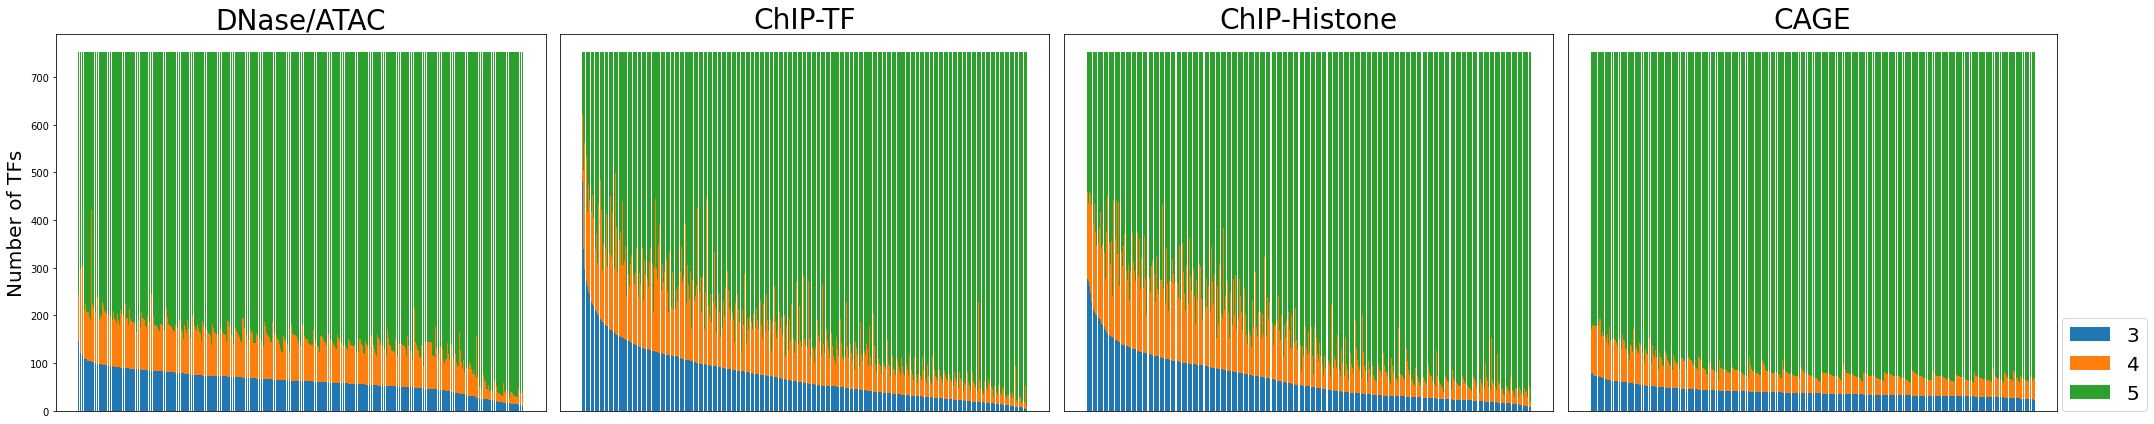

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(30,6))

for i, assay in enumerate(targets_with_assay_type["assay_subtype"].unique()):
    assay_tracks = targets_with_assay_type[targets_with_assay_type["assay_subtype"] == assay]["description"].values
    
    for n in num_models_with_sign_agreement_agg.columns.values:
        num_models_with_sign_agreement_agg_assay = num_models_with_sign_agreement_agg.loc[assay_tracks]
        num_models_with_sign_agreement_agg_assay = num_models_with_sign_agreement_agg_assay.sort_values(by=[3,4,5], ascending=False)
        
        ax[i].bar(np.arange(len(num_models_with_sign_agreement_agg_assay)),
                num_models_with_sign_agreement_agg_assay[n], 
                bottom=num_models_with_sign_agreement_agg_assay[list(range(3, n))].sum(axis=1).values 
                if n > 3 else None,
                label=n)
        if i == 0:
            ax[i].set_ylabel("Number of TFs", fontsize=20)
        else:
            ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title(f"{assay}", fontsize=28)
        
plt.legend(loc=(1.01,0), fontsize=20)
plt.tight_layout()
plt.savefig(f"{plot_dir}/endogenous_sequence_tf_activity_consistency_per_track_by_assay.pdf", dpi=300)

### Fig 2B

Per track consistency for TF activity scores

In [55]:
# for eack track-TF pair, compute the number of models with sign agreement
num_models_with_sign_agreement_all_tracks = []
for track in mutated_tf_activity_scores[1].columns.values:
    num_models_with_sign_agreement = pd.concat([np.sign(mutated_tf_activity_scores[rep][track]) > 0 
                                                for rep in range(1, num_models+1)], axis=1).sum(axis=1)
    num_models_with_sign_agreement = np.abs(num_models_with_sign_agreement - 2.5) + 2.5
    num_models_with_sign_agreement_all_tracks.append(num_models_with_sign_agreement)
num_models_with_sign_agreement_all_tracks = pd.concat(num_models_with_sign_agreement_all_tracks, axis=1)
num_models_with_sign_agreement_all_tracks.columns = mutated_tf_activity_scores[rep].columns.values

# for each track, aggregate info across TFs
num_models_with_sign_agreement_agg = pd.DataFrame(
    [], index=num_models_with_sign_agreement_all_tracks.columns.values, columns=[3,4,5])
for n in num_models_with_sign_agreement_agg.columns.values:
    num_models_with_sign_agreement_agg[n] = (num_models_with_sign_agreement_all_tracks == n).sum(axis=0)
num_models_with_sign_agreement_agg = num_models_with_sign_agreement_agg.sort_values(by=[3,4,5], ascending=False)

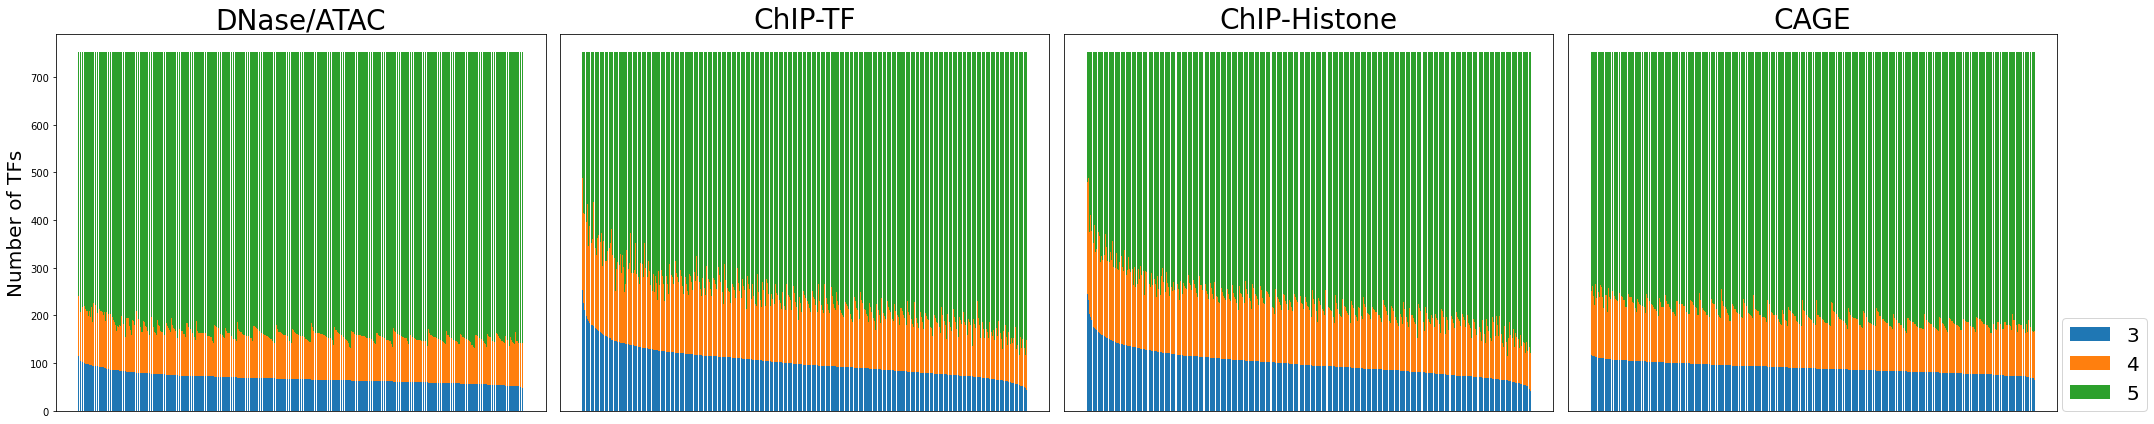

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(30,6))

for i, assay in enumerate(targets_with_assay_type["assay_subtype"].unique()):
    assay_tracks = targets_with_assay_type[targets_with_assay_type["assay_subtype"] == assay]["description"].values
    
    for n in num_models_with_sign_agreement_agg.columns.values:
        num_models_with_sign_agreement_agg_assay = num_models_with_sign_agreement_agg.loc[assay_tracks]
        num_models_with_sign_agreement_agg_assay = num_models_with_sign_agreement_agg_assay.sort_values(by=[3,4,5], ascending=False)
        
        ax[i].bar(np.arange(len(num_models_with_sign_agreement_agg_assay)),
                num_models_with_sign_agreement_agg_assay[n], 
                bottom=num_models_with_sign_agreement_agg_assay[list(range(3, n))].sum(axis=1).values 
                if n > 3 else None,
                label=n)
        if i == 0:
            ax[i].set_ylabel("Number of TFs", fontsize=20)
        else:
            ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title(f"{assay}", fontsize=28)
        
plt.legend(loc=(1.01,0), fontsize=20)
plt.tight_layout()
plt.savefig(f"{plot_dir}/endogenous_sequence_tf_mutation_activity_consistency_per_track_by_assay.pdf", dpi=300)

### Fig S3

Compare TF mutation activity consistency vs PWM mutation probability

In [58]:
# for each TF, aggregate info across tracks
num_models_with_sign_agreement_agg_per_TF = pd.DataFrame([], 
                                                  index=num_models_with_sign_agreement_all_tracks.index.values, 
                                                  columns=[3,4,5])
for n in num_models_with_sign_agreement_agg_per_TF.columns.values:
    num_models_with_sign_agreement_agg_per_TF[n] = (num_models_with_sign_agreement_all_tracks == n).sum(axis=1)
    
num_models_with_sign_agreement_agg_per_TF = num_models_with_sign_agreement_agg_per_TF.sort_values(by=[3,4,5], ascending=False)

In [71]:
# annotate mutation probability from PWM for each mutated TF
for tf in num_models_with_sign_agreement_agg_per_TF.index.values:
    lowest_entropy_pos = np.argmin(stats.entropy(pwms[tf], axis=0))
    mutation_prob = pwms[tf][lowest_entropy_pos+1].min() # +1 because columns are 1-indexed
    num_models_with_sign_agreement_agg_per_TF.loc[tf, "Mutation probability"] = mutation_prob

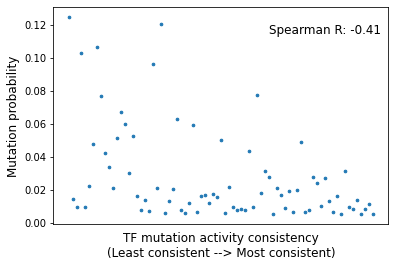

In [72]:
tmp_df = num_models_with_sign_agreement_agg_per_TF[num_models_with_sign_agreement_agg_per_TF["Mutation probability"] > 0.005]

plt.scatter(np.arange(len(tmp_df)),  tmp_df["Mutation probability"], s=7)
corr = stats.spearmanr(np.arange(len(tmp_df)), tmp_df["Mutation probability"])[0]
plt.xticks([])
plt.xlabel("TF mutation activity consistency\n(Least consistent --> Most consistent)", fontsize=12)
plt.ylabel("Mutation probability", fontsize=12)
plt.text(50, 0.115, f"Spearman R: {round(corr, 2)}", fontsize=12)
plt.savefig(f"{plot_dir}/tf_mutation_activity_consistency_vs_mutation_probability.pdf", dpi=300)